In [122]:
import pandas as pd
import xml.etree.ElementTree as ET

DETECTORS_FILE = "lanedetectors.add.xml" 
DATA_FILE = "data2.csv"  
BIN_SIZE = 300  # 5-minute intervals
T_START = 0  # Arbitrary start time for binning

def main():
    global combined_results
    # Load detectors from XML file
    detector_ids = load_detectors_from_xml(DETECTORS_FILE)
    cross_section_map = parse_cross_sections(detector_ids)

    # Aggregate data with binning
    combined_results = combined_output(DATA_FILE, cross_section_map, bin_size=BIN_SIZE, t_start=T_START)

    print(combined_results.head())

    # Save to CSV
    combined_results.to_csv("combined_data.csv", index=False)
    print("Data saved to combined_data.csv")

    return combined_results


def parse_cross_sections(detector_ids):
    """Group detectors into edges by excluding the middle part of the detector ID."""
    cross_section_map = {}
    for detector_id in detector_ids:
        # Extract edge and position by removing the middle part (e.g., E1_0_1000m -> E1_1000m)
        parts = detector_id.split("_")
        if len(parts) == 3:
            edge = f"{parts[0]}_{parts[2]}"  # Combine the first and last parts
        else:
            edge = detector_id  # Fallback for unexpected formats
        cross_section_map[detector_id] = edge
    return cross_section_map

def load_detectors_from_xml(detectors_file):
    """Load detector IDs from the XML file."""
    tree = ET.parse(detectors_file)
    root = tree.getroot()
    detector_ids = [detector.get("id") for detector in root.findall("laneAreaDetector")]
    return detector_ids

def combined_output(csv_file, cs_map, bin_size=300, t_start=0):
    """Aggregates data into time bins and merges detector IDs."""

    # Load CSV file
    df = pd.read_csv(csv_file)

    # Rename columns for consistency
    df.rename(columns={
        "Time (s)": "time",
        "Detector ID": "detectorID",
        "Vehicle Count": "count",
        "Exit flow": "exitFlow",
        "Density (veh/km)": "density",
        "Mean Speed (km/h)": "meanSpeed",
        "Occupancy (%)": "occupancy",
        "Scenario": "scenario"
    }, inplace=True)

    # Map Detector IDs to their simplified names
    df["detectorID"] = df["detectorID"].map(cs_map)

    # Ensure only times from `t_start` onwards are considered
    df = df[df["time"] >= t_start]

    # Create `time_bin` based on `t_start` and `bin_size`
    df["time_bin"] = ((df["time"] - t_start) // bin_size) * bin_size + t_start

    # Ensure we don't mix scenarios when aggregating
    grouped = df.groupby(["time_bin", "detectorID", "scenario"], as_index=False)

    def mean_speed_aggregation(series):
        """Custom aggregation for mean speed based on sign conditions."""
        positive_values = series[series > 0]
        negative_values = series[series < 0]

        if len(positive_values) > 0 and len(negative_values) == 0:
            return positive_values.mean()  # If all > 0, average them
        elif len(positive_values) == 0 and len(negative_values) > 0:
            return negative_values.mean()  # If all < 0, average them
        elif len(positive_values) > 0 and len(negative_values) > 0:
            return positive_values.mean()  # Keep only the > 0 values
        else:
            return 0  # Edge case where all values are zero or NaN
    
    aggregated_df = grouped.agg(
        exitFlow=("exitFlow", "sum"),  # Sum exit flow
        count=("count", "sum"),  # Sum of vehicle counts
        density=("density", "mean"),  # Average density
        meanSpeed=("meanSpeed", mean_speed_aggregation),  # Custom function for speed
        occupancy=("occupancy", "mean")  # Average occupancy
    )

    return aggregated_df

if __name__ == "__main__":
    main()

   time_bin detectorID scenario  exitFlow  count    density   meanSpeed  \
0       0.0      E0_0m   attack       314   1139  19.046823   99.442260   
1       0.0      E0_0m     base       314   1139  19.046823   99.442260   
2       0.0   E0_1000m   attack       266   1066  17.826087   95.904253   
3       0.0   E0_1000m     base       266   1066  17.826087   95.904253   
4       0.0    E0_100m   attack       306   1152  19.264214  100.034059   

   occupancy  
0   9.059760  
1   9.059760  
2   8.482723  
3   8.482723  
4   9.192241  
Data saved to combined_data.csv


In [123]:
def calculate_ratios(data):
    """Calculate Speed Performance Ratio (SPR) and Flow Ratio (FR)."""

    # Separate attack and base scenarios
    attack_data = data[data["scenario"] == "attack"]
    base_data = data[data["scenario"] == "base"]

    # Merge attack and base data for comparison (EXCLUDING scenario from the merge key)
    merged_data = pd.merge(
        attack_data,
        base_data,
        on=["time_bin", "detectorID"],  # Corrected merge condition
        suffixes=("_attack", "_base")
    )

    # Debugging: Check merged data
    print("Merged Data Preview:")
    print(merged_data.head())

    # Calculate SPR and FR
    
    # Speed limit assumption when no vehicles are detected in the base scenario
    SPEED_LIMIT_BASELINE = 112.654

    # Apply new SPR rules
    def compute_spr(row):
        base_speed = row["meanSpeed_base"]
        attack_speed = row["meanSpeed_attack"]

        if base_speed < 0 and attack_speed > 0:
            return round(attack_speed / SPEED_LIMIT_BASELINE, 2)  # SPR using speed limit
        elif base_speed < 0 and attack_speed < 0:
            return -1  # No vehicles in both cases
        elif base_speed > 0 and attack_speed < 0:
            return -2  # Total breakdown in the attack scenario
        else:
            return round(attack_speed / base_speed, 2)  # Normal SPR calculation

    # Apply the SPR function to each row
    merged_data["SPR"] = merged_data.apply(compute_spr, axis=1)

    # Apply the new FR logic
    def compute_fr(row):
        base_flow = row["exitFlow_base"]
        attack_flow = row["exitFlow_attack"]

        if base_flow == 0 and attack_flow > 0:
            return -1  # Attack flow appeared where base flow was 0
        elif base_flow > 0 and attack_flow == 0:
            return 0  # Total failure in attack scenario
        elif base_flow == 0 and attack_flow == 0:
            return 1  # No vehicles in both cases
        else:
            return round(attack_flow / base_flow, 2)  # Normal FR calculation

    # Apply the FR function to each row
    merged_data["FR"] = merged_data.apply(compute_fr, axis=1)

    # Select and format output columns
    output_data = merged_data[[
        "time_bin",
        "detectorID",
        "SPR",
        "FR",
        "meanSpeed_attack",
        "meanSpeed_base",
        "exitFlow_attack",
        "exitFlow_base",
        "density_attack",
        "density_base"
    ]].round(2)  # Round all numeric columns to 2 decimal places

    return output_data

# Load combined data from CSV
comb_results = pd.read_csv("combined_data.csv")

# Calculate ratios and save to CSV
ratios = calculate_ratios(comb_results)
ratios.to_csv("ratios.csv", index=False)
print("Ratios saved to ratios.csv")


Merged Data Preview:
   time_bin detectorID scenario_attack  exitFlow_attack  count_attack  \
0       0.0      E0_0m          attack              314          1139   
1       0.0   E0_1000m          attack              266          1066   
2       0.0    E0_100m          attack              306          1152   
3       0.0   E0_1100m          attack              260          1052   
4       0.0   E0_1200m          attack              258          1032   

   density_attack  meanSpeed_attack  occupancy_attack scenario_base  \
0       19.046823         99.442260          9.059760          base   
1       17.826087         95.904253          8.482723          base   
2       19.264214        100.034059          9.192241          base   
3       17.591973         95.567996          8.396649          base   
4       17.257525         95.467741          8.242514          base   

   exitFlow_base  count_base  density_base  meanSpeed_base  occupancy_base  
0            314        1139     19.

In [124]:
ratios = pd.read_csv("ratios.csv")

# convert veh/km/lane to vveh/mile/lane for density
ratios['density_attack'] = ratios['density_attack'] * 1.60934
ratios['density_base'] = ratios['density_base'] * 1.60934

# Define LOS classification function for urban freeway density
def classify_LOS(density):
    if density <= 11:
        return "A"
    elif 11 < density <= 18:
        return "B"
    elif 18 < density <= 26:
        return "C"
    elif 26 < density <= 35:
        return "D"
    elif 35 < density <= 45:
        return "E"
    else:
        return "F"
    
# Apply LOS classification to both scenarios
ratios["LOS_attack"] = ratios["density_attack"].apply(classify_LOS)
ratios["LOS_base"] = ratios["density_base"].apply(classify_LOS)

# Define function to assign distance based on detectorID
def assign_distance(detector_id):
    """Assigns distance based on the detectorID."""
    if detector_id.startswith("E0_"):
        base_distance = 0
    elif detector_id.startswith("E1_"):
        base_distance = 2000
    elif detector_id.startswith("E2_"):
        base_distance = 4000
    else:
        return None  # If the format doesn't match expected values

    # Extract the numeric part of the detectorID (distance suffix)
    suffix_distance = int(detector_id.split("_")[1][:-1])  # Extract number before 'm'
    
    return base_distance + suffix_distance

ratios["distance"] = ratios["detectorID"].apply(assign_distance)

# Sort the DataFrame
ratios_sorted = ratios.sort_values(by=["time_bin", "distance"], ascending=[True, True])

print(ratios_sorted.head())

# Drop helper columns used for sorting
# ratios_sorted = ratios_sorted.drop(columns=["road", "distance"])



# Save to CSV
ratios_sorted.to_csv("ratios_LOS2.csv", index=False)
print("Ratios saved to ratios_LOS2.csv")



    time_bin detectorID  SPR   FR  meanSpeed_attack  meanSpeed_base  \
0        0.0      E0_0m  1.0  1.0             99.44           99.44   
2        0.0    E0_100m  1.0  1.0            100.03          100.03   
12       0.0    E0_200m  1.0  1.0             99.29           99.29   
13       0.0    E0_300m  1.0  1.0             98.54           98.54   
14       0.0    E0_400m  1.0  1.0             97.88           97.88   

    exitFlow_attack  exitFlow_base  density_attack  density_base LOS_attack  \
0               314            314       30.657927     30.657927          D   
2               306            306       30.995888     30.995888          D   
12              303            303       31.189009     31.189009          D   
13              296            296       31.028075     31.028075          D   
14              289            289       30.786674     30.786674          D   

   LOS_base  distance  
0         D         0  
2         D       100  
12        D       200  
13

0.8888333333333335 0.9809583333333333


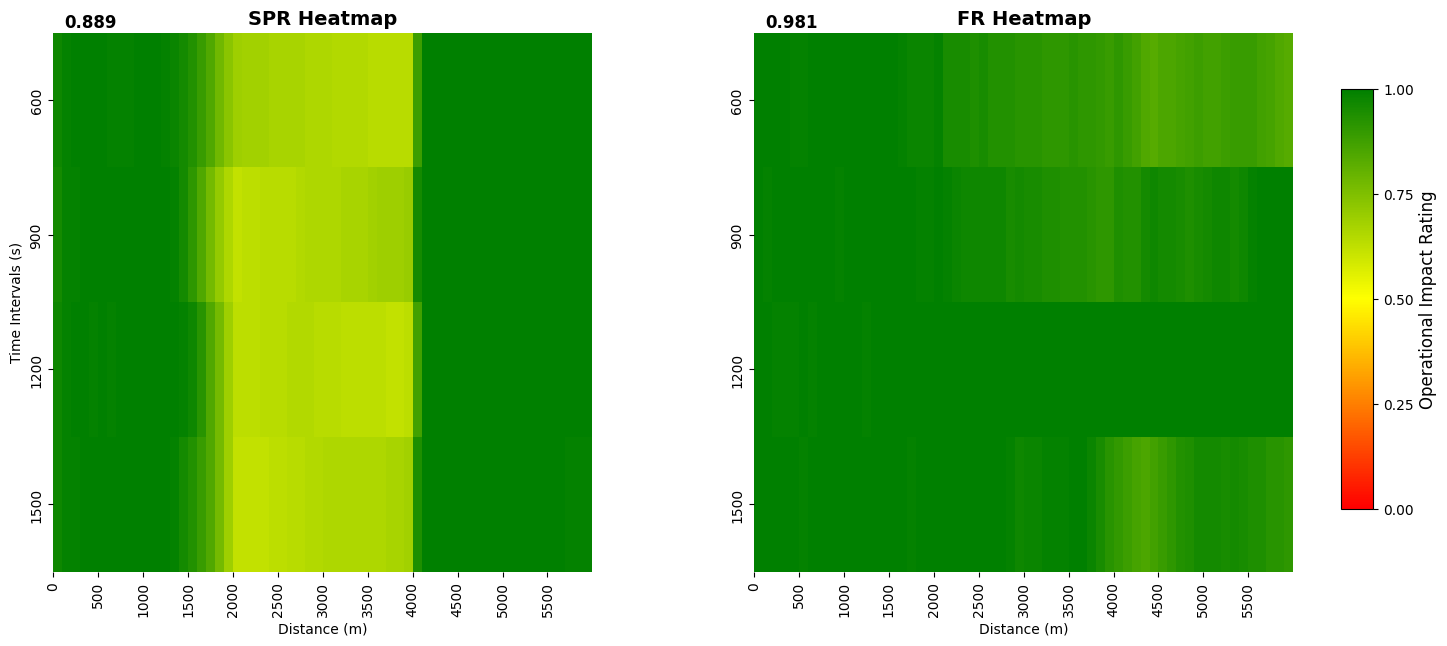

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize, LinearSegmentedColormap

# Load the CSV file with the manually added distance column
file_path = "ratios_LOS2.csv"
df = pd.read_csv(file_path)

# Convert `time_bin` and `distance` to integers for proper sorting and filtering
df["time_bin"] = df["time_bin"].astype(int)
df["distance"] = df["distance"].astype(int)

# Sort data by `time_bin` (ascending) and `distance` (ascending)
df = df.sort_values(by=["time_bin", "distance"])

# Define the range for data to include in the heatmap
distance_start = 0     # Start distance (inclusive)
distance_end = 5900    # End distance (inclusive)
time_start = 600        # Start time (inclusive)
time_end = 1500         # End time (inclusive)

# Adjust time values so the smallest becomes 0
min_time = df["time_bin"].min()
df["adjusted_time"] = df["time_bin"] - min_time

# Filter data based on the defined distance and time ranges
filtered_df = df[(df["distance"] >= distance_start) & (df["distance"] <= distance_end)]
filtered_df = filtered_df[(filtered_df["time_bin"] >= time_start) & (filtered_df["time_bin"] <= time_end)]

# Create pivot tables using `distance` instead of `detectorID`
spr_matrix = filtered_df.pivot(index="adjusted_time", columns="distance", values="SPR")
fr_matrix = filtered_df.pivot(index="adjusted_time", columns="distance", values="FR")

# Calculate the mean for SPR and FR within the specified range
spr_mean = spr_matrix.mean().mean()
fr_mean = fr_matrix.mean().mean()

print(spr_mean, fr_mean)

# Define function to plot the heatmaps
def plot_heatmaps(spr_matrix, fr_matrix):
    cmap = LinearSegmentedColormap.from_list("fixed", ["red", "yellow", "green"], N=256)
    norm = Normalize(vmin=0.0, vmax=1.0)

    fig, axes = plt.subplots(1, 2, figsize=(16, 7), gridspec_kw={'width_ratios': [1, 1], 'wspace': 0.3})
    cbar_ax = fig.add_axes([0.93, 0.2, 0.02, 0.6])

    # SPR Heatmap
    sns.heatmap(spr_matrix, cmap=cmap, norm=norm, cbar=False, ax=axes[0])
    axes[0].set_title("SPR Heatmap", fontsize=14, fontweight="bold")
    axes[0].set_xlabel("Distance (m)")
    axes[0].set_ylabel("Time Intervals (s)")
    axes[0].set_xticks(np.arange(0, len(spr_matrix.columns), 5))
    axes[0].set_xticklabels(spr_matrix.columns[::5], rotation=90)

    # Add SOI value for SPR in the top-left corner
    axes[0].text(
        x=0.02, y=1.02,
        s=f"{spr_mean:.3f}",
        fontsize=12, color="black", fontweight="bold",
        transform=axes[0].transAxes, ha="left", va="center"
    )

    # FR Heatmap
    sns.heatmap(fr_matrix, cmap=cmap, norm=norm, cbar=False, ax=axes[1])
    axes[1].set_title("FR Heatmap", fontsize=14, fontweight="bold")
    axes[1].set_xlabel("Distance (m)")
    axes[1].set_ylabel("")
    axes[1].set_xticks(np.arange(0, len(fr_matrix.columns), 5))
    axes[1].set_xticklabels(fr_matrix.columns[::5], rotation=90)

    # Add SOI value for FR in the top-left corner
    axes[1].text(
        x=0.02, y=1.02,
        s=f"{fr_mean:.3f}",
        fontsize=12, color="black", fontweight="bold",
        transform=axes[1].transAxes, ha="left", va="center"
    )

    # Shared colorbar
    cbar = fig.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), cax=cbar_ax)
    cbar.set_label("Operational Impact Rating", fontsize=12)
    cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(["0.00", "0.25", "0.50", "0.75", "1.00"])

    plt.show()

# Plot the heatmaps
plot_heatmaps(spr_matrix, fr_matrix)
